In [8]:
import copy
from tqdm.auto import tqdm
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    virtual_scan, 
    virtual_mesh_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

from superprimitive_fusion.evaluation import (
    evaluate_mesh_pair,
    tsdf_fuse_from_depth_data,
    mse_and_iou,
)

In [19]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    ('bleach', 'bleach.obj'),
    ('pitcher', 'pitcher.obj'),
    ('mug', 'mug.obj'),
    ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

Getting the mustard-bottle
Getting the table
Getting the power-drill
Getting the bleach
Getting the pitcher
Getting the mug
Getting the extra-large-clamp


In [ ]:
gt_scene_mesh = copy.deepcopy(gt_mesh_list[0])
for i in range(1,len(gt_mesh_list)):
    gt_scene_mesh += gt_mesh_list[i]

In [ ]:
# ok = o3d.io.write_triangle_mesh(str('evaluation/1_nonoise/gt_scene_mesh.obj'), gt_scene_mesh)
# print(ok)

[Open3D WARNING] Write OBJ can not include triangle normals.
True


In [20]:
centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [23]:
cam_offset=obj_centre
look_at = obj_centre
width: int = 360
height: int = 240
fov: float = 70.0
k: float = 10
max_normal_angle_deg = None
include_depth_images = True

scans = []
object_meshes_list = []
depth_data_list = []
ccs = []
a = 45
c = int(360/10)
rs = (0.45, 0.45)
ls = (50, 80)
for i in range(360//c):
    r = rs[0] if i%2==0 else rs[1]
    l = ls[0] if i%2==0 else ls[1]
    ccs.append(cam_offset + polar2cartesian(r=r, lat=l, long=a+i*c))

for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        gt_mesh_list,
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    for mesh in object_meshes:
        mesh.compute_vertex_normals()
    depth_data_list.append(depth_data)
    object_meshes_list.append(object_meshes)
    scans.append([(m,w) for m,w in zip(object_meshes, object_weights)])

In [ ]:
o3d.visualization.draw_geometries(object_meshes_list[0])

{
	"class_name" : "ViewTrajectory",
	"interval" : 29,
	"is_loop" : false,
	"trajectory" : 
	[
		{
			"boundingbox_max" : [ 0.31351301074028015, 0.29815509915351868, 0.97049397230148315 ],
			"boundingbox_min" : [ -0.89998292922973633, -0.44995534420013428, 0.71999996900558472 ],
			"field_of_view" : 60.0,
			"front" : [ 0.22239480699118683, 0.71250457215839402, 0.66549063440197032 ],
			"lookat" : [ -0.013467051735739487, -0.11457863660564925, 0.72834292536380352 ],
			"up" : [ -0.22998261913480553, -0.62498346034109209, 0.74599173534025809 ],
			"zoom" : 0.2639999999999994
		}
	],
	"version_major" : 1,
	"version_minor" : 0
}

In [26]:
import os
def plot_images(images, max_cols=5, titles=None, titlesize=9, per_img_width=3, cmap=None, cbar_cols=None, cbar_kw=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n = len(images)
    h_to_w = images[0].shape[0] / images[0].shape[1]
    cols = max(1, min(max_cols, n))
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*per_img_width, rows*per_img_width*h_to_w), squeeze=False)
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i >= n: ax.axis('off'); continue
        img = images[i]
        arr = plt.imread(img) if isinstance(img, (str, os.PathLike)) else np.asarray(img)
        im = ax.imshow(arr, cmap=(cmap if arr.ndim == 2 else None))
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        if titles and i < len(titles) and titles[i]: ax.set_title(titles[i], fontsize=titlesize, pad=2)
        if arr.ndim == 2 and cbar_cols and (i % cols) in cbar_cols:
            cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.02)
            fig.colorbar(im, cax=cax, **(cbar_kw or {}))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    return fig, axes[:n]

In [135]:
kz, kd = 1, 5

depth_data = depth_data_list[0]

z_img = depth_data['depth']
valid_img = np.isfinite(z_img)

z_val = z_img.copy()
z_val[~valid_img] = 0

disp = np.zeros_like(z_img, dtype=np.float32)
m = valid_img & np.isfinite(z_img) & (z_img > 0)
disp[m] = 1.0 / z_img[m]

dx  = np.abs(disp[:, 1:] - disp[:, :-1])
dy  = np.abs(disp[1:, :] - disp[:-1, :])
dd1 = np.abs(disp[:-1, :-1] - disp[1:, 1:])    # tl-br
dd2 = np.abs(disp[:-1, 1:]  - disp[1:, :-1])   # tr-bl

zdx  = np.abs(z_val[:, 1:] - z_val[:, :-1])
zdy  = np.abs(z_val[1:, :] - z_val[:-1, :])
zdd1 = np.abs(z_val[:-1, :-1] - z_val[1:, 1:])    # tl-br
zdd2 = np.abs(z_val[:-1, 1:]  - z_val[1:, :-1])   # tr-bl

mask_x  = valid_img[:, 1:] & valid_img[:, :-1]
mask_y  = valid_img[1:, :] & valid_img[:-1, :]
mask_d1 = valid_img[:-1, :-1] & valid_img[1:, 1:]
mask_d2 = valid_img[:-1, 1:]  & valid_img[1:, :-1]

vals_dd = np.concatenate([
    dx[mask_x].ravel(), dy[mask_y].ravel(),
    (dd1[mask_d1] / np.sqrt(2)).ravel(),
    (dd2[mask_d2] / np.sqrt(2)).ravel()
])

vals_dz = np.concatenate([
    dx[mask_x].ravel(), dy[mask_y].ravel(),
    (dd1[mask_d1] / np.sqrt(2)).ravel(),
    (dd2[mask_d2] / np.sqrt(2)).ravel()
])

if vals_dd.size:
    med = np.median(vals_dd)
    mad = 1.4826 * np.median(np.abs(vals_dd - med))
    base_thr_dd = med + kd * mad if mad > 0 else med * 1.5
else:
    base_thr_dd = np.inf
thr_x_dd, thr_y_dd, thr_d_dd = base_thr_dd, base_thr_dd, base_thr_dd * np.sqrt(2)

if vals_dz.size:
    med = np.median(vals_dz)
    mad = 1.4826 * np.median(np.abs(vals_dz - med))
    base_thr_dz = med + kz * mad if mad > 0 else med * 1.5
else:
    base_thr_dd = np.inf
thr_x_dz, thr_y_dz, thr_d_dz = base_thr_dz, base_thr_dz, base_thr_dz * np.sqrt(2)

(<Figure size 1500x200 with 5 Axes>,
 array([<Axes: title={'center': 'RGB'}>,
        <Axes: title={'center': 'Disp. diff. x'}>,
        <Axes: title={'center': 'Disp. diff. y'}>,
        <Axes: title={'center': 'Disp. diff. tl-br'}>,
        <Axes: title={'center': 'Disp. diff. bl-tr'}>], dtype=object))

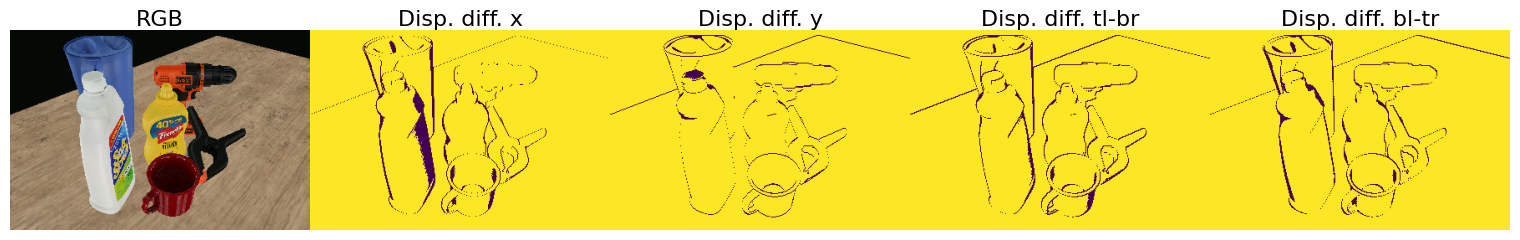

In [136]:
threshed_disp_diffs = [dx<=thr_x_dd, dy<=thr_y_dd, dd1<=thr_d_dd, dd2<=thr_d_dd]
threshed_disp_diffs = [np.flip(dd, axis=[0,1]) for dd in [depth_data['rgb']]+threshed_disp_diffs]
plot_images(threshed_disp_diffs, titles=['RGB', 'Disp. diff. x', 'Disp. diff. y', 'Disp. diff. tl-br', 'Disp. diff. bl-tr'], titlesize=16)
# plt.savefig('../screenshots/disp_diff_1.png')

(<Figure size 1500x200 with 5 Axes>,
 array([<Axes: title={'center': 'RGB'}>,
        <Axes: title={'center': 'Img. grad. x'}>,
        <Axes: title={'center': 'Img. grad. y'}>,
        <Axes: title={'center': 'Img. grad. tl-br'}>,
        <Axes: title={'center': 'Img. grad. bl-tr'}>], dtype=object))

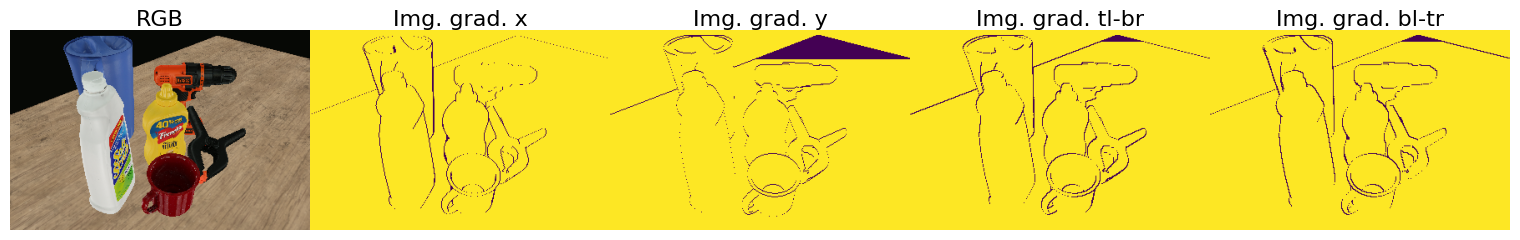

In [128]:
threshed_disp_diffs = [zdx<=thr_x_dz, zdy<=thr_y_dz, zdd1<=thr_d_dz, zdd2<=thr_d_dz]
threshed_disp_diffs = [np.flip(dd, axis=[0,1]) for dd in [depth_data['rgb']]+threshed_disp_diffs]
plot_images(threshed_disp_diffs, titles=['RGB', 'Img. grad. x', 'Img. grad. y', 'Img. grad. tl-br', 'Img. grad. bl-tr'], titlesize=16)
# plt.savefig('../screenshots/disp_diff_1.png')

(np.float64(-0.5), np.float64(1519.5), np.float64(479.5), np.float64(-0.5))

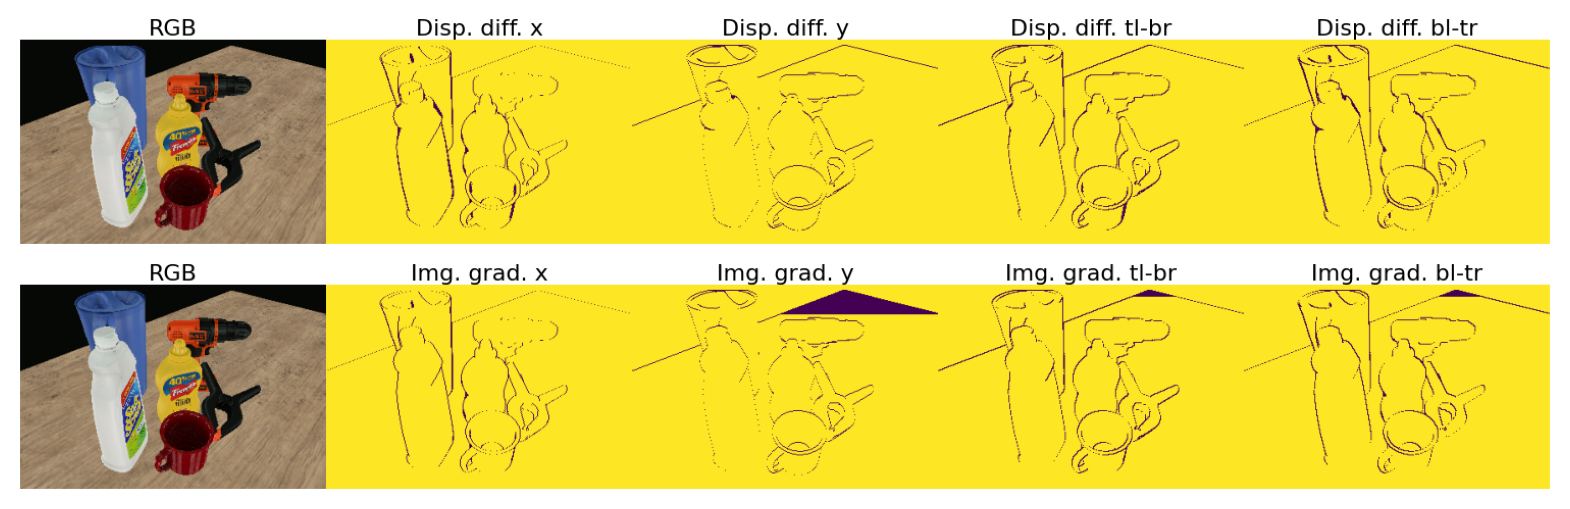

In [129]:
img1 = plt.imread('../screenshots/disp_diff_1.png')
img2 = plt.imread('../screenshots/disp_diff_2.png')
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([img1, img2], axis=0))
plt.axis('off')

In [18]:
diff_mesh_colours = distinct_colours(len(scan_meshes))
diff_col_meshes = []
for i,mesh in enumerate(scan_meshes):
    if len(np.asarray(mesh.vertices)) == 0:
        continue
    col_mesh = copy.deepcopy(mesh)
    col_mesh.compute_vertex_normals()
    col_mesh.paint_uniform_color(diff_mesh_colours[i])
    diff_col_meshes.append(col_mesh)

o3d.visualization.draw_geometries(diff_col_meshes)

In [6]:
from superprimitive_fusion.evaluation import tsdf_fuse
from superprimitive_fusion.utils import plot_images

def precompute_per_segment_depth_images(scene_depth_data):
    per_seg_depth_images = []

    segmt3d = np.array([d['segmt'] for d in scene_depth_data])
    depth3d = np.array([d['depth'] for d in scene_depth_data])

    seg_ids = np.unique(segmt3d)
    for seg_id in seg_ids:
        depth3d_masked = depth3d.copy()
        mask = (segmt3d!=seg_id) | ~np.isfinite(depth3d)
        depth3d_masked[mask] = 0
        seg_depth_images = [depth3d_masked[i,...] for i in range(depth3d.shape[0])]
        per_seg_depth_images.append(seg_depth_images)
    return per_seg_depth_images

def tsdf_fuse_scene_from_depth_data(depth_data, per_seg_depth_images, voxel_length=1./1024, trunc_voxels=5):
    assert isinstance(per_seg_depth_images, list) and isinstance(per_seg_depth_images[0], list)
    fused_meshes = []

    K = depth_data[0]['K_t']

    rgb_list  = [d['rgb'] for d in depth_data]
    T_wc_list = [d['E'] for d in depth_data]

    for seg_depth_images in per_seg_depth_images:
        mesh = tsdf_fuse(
            seg_depth_images, rgb_list, K, T_wc_list,
            voxel_length=voxel_length,
            trunc_voxels=trunc_voxels,
        )
        fused_meshes.append(mesh)
    return fused_meshes

per_seg_depth_images = precompute_per_segment_depth_images(scene_depth_data=depth_data_list)

In [12]:
%%time
# tsdf_lo_meshes = tsdf_fuse_scene_from_depth_data(depth_data=depth_data_list, per_seg_depth_images=per_seg_depth_images, voxel_length=1/1000, trunc_voxels=4)
tsdf_lo_mesh = tsdf_fuse_from_depth_data(depth_data=depth_data_list, voxel_length=1/295, trunc_voxels=5)
print(f'The low TSDF mesh has {len(np.asarray(tsdf_lo_mesh.triangles))} triangles')

The low TSDF mesh has 438315 triangles
CPU times: user 509 ms, sys: 307 ms, total: 816 ms
Wall time: 267 ms


In [13]:
o3d.visualization.draw_geometries([tsdf_lo_mesh])

In [14]:
%%time
tsdf_lo_mesh_smth = tsdf_lo_mesh.filter_smooth_simple(number_of_iterations=1)
tsdf_lo_mesh_smth.compute_vertex_normals()

CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 50.3 ms


TriangleMesh with 227510 points and 438315 triangles.

In [15]:
o3d.visualization.draw_geometries([tsdf_lo_mesh_smth])

In [16]:
%%time
# tsdf_hi_meshes = tsdf_fuse_scene_from_depth_data(depth_data=depth_data_list, per_seg_depth_images=per_seg_depth_images, voxel_length=1/1000, trunc_voxels=4)
tsdf_hi_mesh = tsdf_fuse_from_depth_data(depth_data=depth_data_list, voxel_length=1/1000, trunc_voxels=12)
print(f'The high TSDF mesh has {len(np.asarray(tsdf_hi_mesh.triangles))} triangles')

The high TSDF mesh has 4768872 triangles
CPU times: user 7.08 s, sys: 2.97 s, total: 10 s
Wall time: 4.24 s


In [18]:
o3d.visualization.draw_geometries([tsdf_hi_mesh])

In [17]:
%%time
tsdf_hi_mesh_smth = tsdf_hi_mesh.filter_smooth_simple(number_of_iterations=3)
tsdf_hi_mesh_smth.compute_vertex_normals()

CPU times: user 737 ms, sys: 3.76 ms, total: 741 ms
Wall time: 738 ms


TriangleMesh with 2407684 points and 4768872 triangles.

In [19]:
o3d.visualization.draw_geometries([tsdf_hi_mesh_smth])

In [5]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
        mesh1, weights1 = fused_scan[obj_id]
        mesh2, weights2 = scan[obj_id]

        if len(np.asarray(mesh1.vertices)) == 0:
            tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh2, weights2
        elif len(np.asarray(mesh2.vertices)) == 0:
            tqdm.write(f"Scan {t} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh1, weights1
        else:
            fused_obj_mesh, fused_obj_weights = fuse_meshes(
                mesh1=mesh1, weights1=weights1,
                mesh2=mesh2, weights2=weights2,
                # h_alpha             = 3,
                # r_alpha             = 3,
                # nrm_shift_iters     = 2,
                # nrm_smth_iters      = 1,
                # sigma_theta         = 0.1,
                # normal_diff_thresh  = 20.0,
                # tau_max = None,
                # shift_all = False,
                # ball_radius_percentiles = [1,5,15,30,50,70,85,95,99],
                # bilateral_weight_update = False,
                h_alpha=5.0, r_alpha=2.0,
                nrm_shift_iters=1, nrm_smth_iters=1,
                sigma_theta=0.15,
                normal_diff_thresh=20,
                ball_radius_percentiles=[10,50,90],
                bilateral_weight_update=False,
                shift_all=False,
            )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

spf_unc_meshes = [obj[0] for obj in fused_scan]
spf_unc_mesh = spf_unc_meshes[0]
for i in range(1,len(spf_unc_meshes)):
    spf_unc_mesh += spf_unc_meshes[i]
print(f'The SPF unc mesh has {len(np.asarray(spf_unc_mesh.triangles))} triangles')

Scan:   0%|          | 0/9 [00:00<?, ?scan/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 5 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 6 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 7 obj 2 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

The SPF unc mesh has 453308 triangles


In [6]:
o3d.visualization.draw_geometries([spf_unc_mesh])

In [7]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
        mesh1, weights1 = fused_scan[obj_id]
        mesh2, weights2 = scan[obj_id]

        if len(np.asarray(mesh1.vertices)) == 0:
            tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh2, weights2
        elif len(np.asarray(mesh2.vertices)) == 0:
            tqdm.write(f"Scan {t} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh1, weights1
        else:
            fused_obj_mesh, _ = fuse_meshes(
                mesh1=mesh1, weights1=None,
                mesh2=mesh2, weights2=None,
                # h_alpha             = 3,
                # r_alpha             = 3,
                # nrm_shift_iters     = 2,
                # nrm_smth_iters      = 1,
                # sigma_theta         = 0.1,
                # normal_diff_thresh  = 20.0,
                # tau_max = None,
                # shift_all = False,
                # ball_radius_percentiles = [1,5,15,30,50,70,85,95,99],
                # bilateral_weight_update = False,
                h_alpha=5.0, r_alpha=2.0,
                nrm_shift_iters=1, nrm_smth_iters=1,
                sigma_theta=0.15,
                normal_diff_thresh=20,
                ball_radius_percentiles=[1,5,10,15,25,35,50,90],
                bilateral_weight_update=False,
                shift_all=False,
            )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

spf_van_meshes = [obj[0] for obj in fused_scan]
spf_van_mesh = spf_van_meshes[0]
for i in range(1,len(spf_van_meshes)):
    spf_van_mesh += spf_van_meshes[i]
print(f'The SPF van mesh has {len(np.asarray(spf_van_mesh.triangles))} triangles')

Scan:   0%|          | 0/9 [00:00<?, ?scan/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 5 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 6 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 7 obj 2 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

The SPF van mesh has 431616 triangles


In [8]:
o3d.visualization.draw_geometries([spf_van_mesh])

In [14]:
spf_unc_mesh = o3d.io.read_triangle_mesh('evaluation/1_nonoise/scene/1_scene_spf_unc.ply')
spf_van_mesh = o3d.io.read_triangle_mesh('evaluation/1_nonoise/scene/1_scene_spf_van.ply')

In [ ]:
# rt = 'evaluation/1_nonoise/scene/1_scene_'
# ext = '.ply'
# meshes_and_names = [
#     (spf_unc_mesh, 'spf_unc'),
#     (spf_van_mesh, 'spf_van'), 
#     (tsdf_lo_mesh, 'tsdf_lo'), 
#     (tsdf_lo_mesh_smth, 'tsdf_lo_smth'),
#     # (tsdf_hi_mesh, 'tsdf_hi'), 
#     # (tsdf_hi_mesh_smth, 'tsdf_hi_smth'),
# ]
# for mesh_to_write,fname in meshes_and_names:
#     ok = o3d.io.write_triangle_mesh(rt+fname+ext, mesh_to_write)
#     if not ok:
#         raise RuntimeError(f"Failed to write mesh: {fname}")

In [ ]:
res = evaluate_mesh_pair('evaluation/1_nonoise/gt_scene_mesh.ply', spf_unc_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/evaluation.py:86: UserWarning: Deprecated Function Warning: use 'mesh_number()' instead.
  except Exception: return [i for i in range(ms.number_meshes())]


In [ ]:
res = evaluate_mesh_pair(gt_mesh, spf_van_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 4.0384852380717256e-05, 'median': 1.7132701139285084e-05, 'rms': 7.524295606832672e-05, 'p95': 0.0001395806485170233, 'p99': 0.00035224874428021444, 'hausdorff': 0.0007376469518846074, 'trimmed_hausdorff_99': 0.00035224874428021444, 'count': 150000}, 'gt_to_recon': {'mean': 4.270451252663487e-05, 'median': 1.73756302581686e-05, 'rms': 8.345590710805457e-05, 'p95': 0.00014688153927260158, 'p99': 0.00038730854653130036, 'hausdorff': 0.0009785458782574086, 'trimmed_hausdorff_99': 0.00038730854653130036, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9809066666666667, 'recall': 0.97676, 'fscore': 0.9788289416652477}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9977666666666667, 'recall': 0.99582, 'fscore': 0.9967923829078579}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 1.0, 'fscore': 1.0}, 0.002: {'tau_m': 0.002, '

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_lo_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.00011092313379871096, 'median': 8.34117831873607e-05, 'rms': 0.00015213555092778548, 'p95': 0.0003087966048076047, 'p99': 0.0004935521555266538, 'hausdorff': 0.0016186546227601184, 'trimmed_hausdorff_99': 0.0004935521555266538, 'count': 150000}, 'gt_to_recon': {'mean': 0.00010395317678521375, 'median': 8.059037894918297e-05, 'rms': 0.00013830723774120756, 'p95': 0.00028419230635734195, 'p99': 0.00042503903324442956, 'hausdorff': 0.0009138957998547914, 'trimmed_hausdorff_99': 0.00042503903324442956, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9116466666666667, 'recall': 0.92692, 'fscore': 0.9192198940478997}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9905266666666667, 'recall': 0.9957066666666666, 'fscore': 0.9931099120725438}, 0.001: {'tau_m': 0.001, 'precision': 0.9997466666666667, 'recall': 1.0, 'fscore': 0.999

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_lo_mesh_smth, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 7.352038227595891e-05, 'median': 5.548410136772125e-05, 'rms': 0.0001001215368255377, 'p95': 0.00020496659091981672, 'p99': 0.00032492141235117766, 'hausdorff': 0.000893037585018811, 'trimmed_hausdorff_99': 0.00032492141235117766, 'count': 150000}, 'gt_to_recon': {'mean': 7.424136198636982e-05, 'median': 5.545155079813083e-05, 'rms': 0.00010249635483444255, 'p95': 0.00020629872715625846, 'p99': 0.0003357382115314736, 'hausdorff': 0.0010869523918122827, 'trimmed_hausdorff_99': 0.0003357382115314736, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9740066666666667, 'recall': 0.97272, 'fscore': 0.973362908129544}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9990733333333334, 'recall': 0.99804, 'fscore': 0.9985563993363754}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 0.9999933333333333, 'fscore': 0.9999966666555555}

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_hi_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.00011092313379871096, 'median': 8.34117831873607e-05, 'rms': 0.00015213555092778548, 'p95': 0.0003087966048076047, 'p99': 0.0004935521555266538, 'hausdorff': 0.0016186546227601184, 'trimmed_hausdorff_99': 0.0004935521555266538, 'count': 150000}, 'gt_to_recon': {'mean': 0.00010395317678521375, 'median': 8.059037894918297e-05, 'rms': 0.00013830723774120756, 'p95': 0.00028419230635734195, 'p99': 0.00042503903324442956, 'hausdorff': 0.0009138957998547914, 'trimmed_hausdorff_99': 0.00042503903324442956, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9116466666666667, 'recall': 0.92692, 'fscore': 0.9192198940478997}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9905266666666667, 'recall': 0.9957066666666666, 'fscore': 0.9931099120725438}, 0.001: {'tau_m': 0.001, 'precision': 0.9997466666666667, 'recall': 1.0, 'fscore': 0.999

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_hi_mesh_smth, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 7.352038227595891e-05, 'median': 5.548410136772125e-05, 'rms': 0.0001001215368255377, 'p95': 0.00020496659091981672, 'p99': 0.00032492141235117766, 'hausdorff': 0.000893037585018811, 'trimmed_hausdorff_99': 0.00032492141235117766, 'count': 150000}, 'gt_to_recon': {'mean': 7.424136198636982e-05, 'median': 5.545155079813083e-05, 'rms': 0.00010249635483444255, 'p95': 0.00020629872715625846, 'p99': 0.0003357382115314736, 'hausdorff': 0.0010869523918122827, 'trimmed_hausdorff_99': 0.0003357382115314736, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9740066666666667, 'recall': 0.97272, 'fscore': 0.973362908129544}, 0.0005: {'tau_m': 0.0005, 'precision': 0.9990733333333334, 'recall': 0.99804, 'fscore': 0.9985563993363754}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 0.9999933333333333, 'fscore': 0.9999966666555555}

In [ ]:
spf_unc_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [spf_unc_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    spf_unc_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [136]:
spf_van_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [spf_van_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    spf_van_eval_depth_data.append(depth_data)

In [134]:
tsdf_lo_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_lo_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_lo_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [135]:
tsdf_lo_smth_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_lo_mesh_smth],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_lo_smth_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [ ]:
tsdf_hi_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_hi_mesh],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_hi_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [ ]:
tsdf_hi_smth_eval_depth_data = []
for cc in ccs:
    object_meshes, object_weights, depth_data = virtual_mesh_scan(
        [tsdf_hi_mesh_smth],
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =0,#2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =0,#1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =0,#2e-4,      # constant perlin noise term
        linear_perlin_sigma     =0,#2e-3,      # linear depth term
        quadrt_perlin_sigma     =0,#1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =0,#1e-4,      # std of per-segment scale noise
        rot_std                 =0,#1e-4,      # std of global rotation noise
        trn_std                 =0,#1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    tsdf_hi_smth_eval_depth_data.append(depth_data)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [137]:
print(mse_and_iou(depth_data_list, spf_unc_eval_depth_data)['overall'])

{'mse': 0.0012201191663887302, 'iou': 0.9932613579308203}


In [139]:
print(mse_and_iou(depth_data_list, spf_van_eval_depth_data)['overall'])

{'mse': 0.0036101242065795284, 'iou': 0.9793138654316079}


In [140]:
print(mse_and_iou(depth_data_list, tsdf_lo_eval_depth_data)['overall'])

{'mse': 0.003329867925109111, 'iou': 0.9781751617270619}


In [ ]:
print(mse_and_iou(depth_data_list, tsdf_lo_smth_eval_depth_data)['overall'])

{'mse': 0.003778855060117283, 'iou': 0.975867342140633}


In [ ]:
print(mse_and_iou(depth_data_list, tsdf_hi_eval_depth_data)['overall'])

{'mse': 0.003329867925109111, 'iou': 0.9781751617270619}


In [ ]:
print(mse_and_iou(depth_data_list, tsdf_hi_smth_eval_depth_data)['overall'])

{'mse': 0.003778855060117283, 'iou': 0.975867342140633}
